In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import math

import random
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
df_pre = pd.read_csv("final_df.csv")

In [3]:
df_pre.rename(columns={"polarity":"Polarity", "words":"Words"}, inplace=True)
for col in df_pre.columns:
    if col!='Words':
        df_pre[col] = df_pre[col].astype(np.int8)
df_pre['Words'] = df_pre['Words'].apply(lambda x: ast.literal_eval(x))

In [4]:
df_pre.head()

,Polarity,Words,Fri,Mon,Sat,Sun,Thu,Tue,Wed,h_00,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
0,0,"{'awww': 1, 'bummer': 1, 'shoulda': 1, 'david'...",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,"{'upset': 1, 'notupdate': 1, 'facebook': 1, 't...",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,"{'dive': 1, 'many': 1, 'time': 1, 'ball': 1, '...",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,"{'whole': 1, 'body': 1, 'feel': 1, 'itchy': 1,...",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,"{'mad': 1, 'notsee': 1}",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [5]:
df_words = df_pre.iloc[:,1]
all_words = {}
i = 0
for dic in df_pre['Words']:
    for word in dic:
        if word not in all_words:
            all_words[word] = i
            i += 1
len(all_words)

6839

In [6]:
from sklearn.utils import shuffle
df_pre = shuffle(df_pre)
df_pre.reset_index(inplace=True, drop=True)
df_pre.head()

,Polarity,Words,Fri,Mon,Sat,Sun,Thu,Tue,Wed,h_00,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
0,0,"{'even': 1, 'sound': 1, 'like': 1, 'mind': 1, ...",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,"{'sunshine': 2, 'super': 1, 'til': 1}",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,"{'also': 1, 'check': 1, 'plugin': 1, 'tweet': ...",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,{'watch': 1},0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,"{'feel': 1, 'sigh': 1}",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# gets the hour
hour_col = np.argmax(np.array(df_pre.iloc[:,9:]), axis = 1)

In [8]:
df = df_pre.iloc[:,:9]
df['Hour'] = hour_col / 23
df.head()

,Polarity,Words,Fri,Mon,Sat,Sun,Thu,Tue,Wed,Hour
0,0,"{'even': 1, 'sound': 1, 'like': 1, 'mind': 1, ...",0,1,0,0,0,0,0,0.173913
1,1,"{'sunshine': 2, 'super': 1, 'til': 1}",1,0,0,0,0,0,0,0.391304
2,1,"{'also': 1, 'check': 1, 'plugin': 1, 'tweet': ...",0,1,0,0,0,0,0,0.217391
3,1,{'watch': 1},0,0,0,1,0,0,0,0.478261
4,1,"{'feel': 1, 'sigh': 1}",1,0,0,0,0,0,0,0.086957


In [9]:
df.shape

(1496338, 10)

In [10]:
# Train test split
X_train = df.iloc[:1000000,1:]
y_train = df.iloc[:1000000,0]
X_test = df.iloc[1000000:1486000,1:]
y_test = df.iloc[1000000:1486000,0]
X_valid = df.iloc[1486000:,1:]
y_valid = df.iloc[1486000:,0]

In [11]:
class Adam():
    def __init__(self,lr=0.01,beta1=0.9,beta2=0.999):
            self.alpha = lr
            self.beta1 = beta1
            self.beta2 = beta2
            self.v = []
            self.s = []

    def init_params(self,layers):
        self.v.clear()
        self.s.clear()
        for layer in layers:
            w = np.zeros_like(layer.W)
            b = np.zeros_like(layer.b)
            self.v.append([w,b])
            self.s.append([w,b])

    def update(self,layers,N):
        for i in range(len(layers)):
            self.v[i][0] = self.beta1 * self.v[i][0] + (1-self.beta1) * layers[i].dW
            self.v[i][1] = self.beta1 * self.v[i][1] + (1-self.beta1) * layers[i].db

            self.s[i][0] = self.beta2 * self.s[i][0] + (1-self.beta2) * np.square(layers[i].dW)
            self.s[i][1] = self.beta2 * self.s[i][1] + (1-self.beta2) * np.square(layers[i].db)

            deltaW = (-1 * self.alpha * self.v[i][0]) / (np.sqrt(self.s[i][0] + 0.001))
            deltab = (-1 * self.alpha * self.v[i][1]) / (np.sqrt(self.s[i][1] + 0.001))

            layers[i].W = layers[i].W + deltaW/N
            layers[i].b = layers[i].b + deltab/N

In [12]:
class layer():
    def __init__(self,n_output,n_input,type_, activation="sigmoid",parameter_initializer="uniform",target=None):
        self.n_output = n_output
        self.n_input = n_input
        self.activation = self.get_activations()[activation]
        self.act_name = activation
        self.target = target
        self.type = type_
        
        # Trying different weight initializations
        if parameter_initializer == "he_normal":
            self.W = np.random.randn(self.n_output,self.n_input)*np.sqrt(2/self.n_input)
            self.b = np.random.randn(self.n_output,1)*np.sqrt(2/self.n_input)
        elif parameter_initializer == "normal":
            self.W = np.random.randn(0, 1, (self.n_output,self.n_input))
            self.b = np.random.randn(0, 1, (self.n_output,1))
        elif parameter_initializer == "uniform":
            self.W = np.random.uniform(-0.05,0.05,(self.n_output,self.n_input))
            self.b = np.random.uniform(-0.05,0.05,(self.n_output,1))
            
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

        self.Z = None
        self.X = None
       
    def _onehot(self, a, M):
        b = np.zeros( (a.size, M), dtype = 'int')
        b[ np.arange(a.size), a] = 1
        return b.T
        
    def sigmoid(self, z):
        return (1/(1+np.exp(-1*z)))

    def _diff_sigmoid(self, z):
        sig = self.sigmoid(z)
        return sig * (1-sig)

    def softmax(self, z):
        exp = np.exp(z)
        tot = exp.sum(axis=0)
        t = exp/tot
        return t

    def _diff_softmax(self,z,y):
        yhat_r = self.softmax(z)
        onehotY = self._onehot(y,z.shape[0])
        one_yi = onehotY *-1*(1-yhat_r)
        z = (1-onehotY)*yhat_r
        return one_yi +z

    def get_activations(self):
        return {"softmax":self.softmax, "sigmoid":self.sigmoid}

    def get_activations_diff(self):
        return {"softmax":self._diff_softmax, "sigmoid":self._diff_sigmoid}

    def get_params(self):
        return [self.W, self.b]

    def zeroing_delta(self):
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def _set_target(self, t):
        self.target = t

    def forward(self,input_, t = False):
        self.X = input_
        z = np.dot(self.W, self.X)+self.b
        A = self.activation(z)
        self.Z = z
        
        return A
    
    def backward(self,input_):
        if self.act_name == "softmax":
            f_dash = self._diff_softmax(self.Z,self.target)
        else:
            f_dash = self.get_activations_diff()[self.act_name](self.Z)

        e = np.ones((self.X.shape[1],1))
        bet = input_ * f_dash
        
        self.dW = self.dW + np.dot(bet,self.X.T)
        self.db = self.db + np.dot(bet,e)
        
        return np.dot(self.W.T, bet)

In [13]:
class Model():
    def __init__(self,all_words,optimizer):
        self.layers = []
        self.all_words = all_words
        self.optimizer = optimizer

    
    def SoftmaxLogLikelihood(self,y,yhat):
        onehotY= self._onehot(y,yhat.shape[0])
        yhat_r = np.max(onehotY*yhat, axis=0,keepdims=True)
        return (1/(y.shape[0]))*-1*np.sum(np.log(yhat_r))
    
    def _onehot(self, a, M):
        b = np.zeros( (a.size, M), dtype = 'int')
        b[ np.arange(a.size), a] = 1
        return b.T
        
    def transform_words(self, x):
        encoding = np.zeros(len(self.all_words))
        i = 0
        for word in x:
            if word in self.all_words:
                encoding[self.all_words[word]] = 1
        return encoding.astype(np.int8)
    
    def add(self,layer):
        self.layers.append(layer)
    
    def forward(self,input_):
        X_words = input_[8:,:]
        X_time = input_[:8,:]
        
        layer_index = 0
        while layer_index < len(self.layers):
            layer = self.layers[layer_index]
            if layer.type != "word_embedding":
                break
            layer_index += 1
            X_words = layer.forward(X_words)
                    
        a = np.concatenate((X_words, X_time), axis=0)
        while layer_index < len(self.layers):
            layer = self.layers[layer_index]
            t = False
            a = layer.forward(a, t)
            layer_index += 1

        return a
    
    def backward(self,input_):
        gd = input_
        layer_index = len(self.layers) - 1
        
        while layer_index>=0:
            layer=self.layers[layer_index]
            if layer.type != 'full':
                break
            layer_index -=1
            gd = layer.backward(gd)
            
        nout_time = 8
        gd_words = gd[:gd.shape[0] - nout_time,:]
        gd_time = gd[gd.shape[0]-nout_time:,:]
    
        while layer_index >= 0:
            layer = self.layers[layer_index]
            layer_index -= 1
            gd_words = layer.backward(gd_words)
            
            
    def zeroing(self):
        for layer in self.layers:
            layer.zeroing_delta()
            

    def batch(self,x,y,bs):
        x = x.copy()
        y = y.copy()
        rem = x.shape[0] % bs

        for i in range(0,x.shape[0],bs):
            yield (x[i:i+bs],y[i:i+bs])
        
        if rem !=0:
            yield (x[x.shape[0]-rem:],y[x.shape[0]-rem:] )

    def fit(self,train_data,validation_data=None, batch_size=32, epochs=5):
        x_train = train_data[0]
        y_train = train_data[1]
        no_of_batches_train = np.ceil(x_train.shape[0]/batch_size)
       
        if validation_data:
            x_valid = validation_data[0]
            y_valid = validation_data[1]
        
        for i in range(epochs):
            self.optimizer.init_params(self.layers)
            print()
            print("Epoch {}/{}".format(i+1,epochs))
            j = 0
            k = 0
            data = self.batch(x_train,y_train,batch_size)
            losses = []
            
            for temp_x,temp_y in data:
                k += 1
                curr_x = temp_x.copy()
                curr_y = temp_y.copy()
                
                word_encodings = []
                for dic in curr_x[:,0]:
                    word_encodings.append(self.transform_words(dic))
                words = np.array(word_encodings)
                curr_x = curr_x[:,1:].astype(np.int8)
                curr_x = np.concatenate((curr_x, words), axis=1)
    
                curr_x = curr_x.T
                curr_y = curr_y.T
                y_hat = self.forward(curr_x)            
                
                # knowing that the loss is SoftmaxLogLikelihood
                self.layers[-1]._set_target(curr_y)
                self.backward(1)
                
                if int(0.1 * no_of_batches_train) == (k):
                    print("=", end = "")
                    k = 0
                
                losses.append(self.SoftmaxLogLikelihood(curr_y,y_hat))

                if j == no_of_batches_train-1:
                    loss = sum(losses) / len(losses)
                    print()
                    print("loss: {}....".format(loss),end=" ")

                if batch_size == 1:
                    N = train_data[0].shape[0]
                else:
                    N = curr_x.shape[-1]
                
                self.optimizer.update(self.layers,N)
                self.zeroing()
                j += 1 
            
            ###
            if validation_data:
                y_hat_val = self.forward(x_valid.T)
                loss_val= self.SoftmaxLogLikelihood(y_valid.T,y_hat_val)
                print("val_loss: {}....".format(loss_val),end=" ")
            ###

    def predict(self,data):
        
        word_encodings = []
        for dic in data[:,0]:
            word_encodings.append(self.transform_words(dic))
        words = np.array(word_encodings)
        data = data[:,1:].astype(np.int8)
        data = np.concatenate((data, words), axis = 1)
        
        y_hat= self.forward(data.T)
        return y_hat.T
    
    
    def get_weights(self):
        params=[]
        for layer in self.layers:
            params.append(layer.get_params())
        
        return params

In [14]:
X_valid

,Words,Fri,Mon,Sat,Sun,Thu,Tue,Wed,Hour
1486000,"{'aww': 1, 'well': 1, 'soon': 1}",0,0,1,0,0,0,0,0.826087
1486001,"{'notwork': 1, 'twitter': 1}",0,0,0,1,0,0,0,0.826087
1486002,"{'think': 1, 'work': 1, 'every': 1, 'pen': 1, ...",0,0,1,0,0,0,0,0.608696
1486003,"{'seriously': 1, 'lolz': 1, 'want': 1, 'back':...",0,0,0,1,0,0,0,0.217391
1486004,"{'would': 1, 'suggest': 1, 'avoid': 1, 'living...",0,0,0,0,1,0,0,0.347826
...,...,...,...,...,...,...,...,...,...
1496333,"{'omg': 1, 'must': 1, 'black': 1, 'bag': 1, 'w...",0,0,0,1,0,0,0,0.913043
1496334,"{'girl': 1, 'mirror': 1, 'wait': 1}",0,1,0,0,0,0,0,0.173913
1496335,"{'grow': 1, 'notsure': 1, 'like': 1}",0,0,0,0,0,0,1,0.217391
1496336,"{'yes': 1, 'still': 1, 'require': 1, 'lot': 1,...",0,0,1,0,0,0,0,0.434783


In [15]:
def transform_words( x):
    encoding = np.zeros(len(all_words))
    i = 0
    for word in x:
        if word in all_words:
            encoding[all_words[word]] = 1
    return encoding.astype(np.int8)
    

In [16]:
X_valid = np.array(X_valid)
word_encodings = []
for dic in X_valid[:,0]:
    word_encodings.append(transform_words(dic))
words = np.array(word_encodings)
X_valid = X_valid[:,1:].astype(np.int8)
X_valid = np.concatenate((X_valid, words), axis=1)

In [17]:
adam = Adam(lr = 0.5)
NN = Model(all_words, optimizer=adam)
in_words = layer(8, len(all_words), "word_embedding")
hidden_words = layer(10, 8, "word_embedding")
full_hidden = layer(4, 18, "full")
full_out = layer(2, 4, "full", activation="softmax")
NN.add(in_words)
NN.add(hidden_words)
NN.add(full_hidden)
NN.add(full_out)


validationData=(X_valid, y_valid)

train_data = (np.array(X_train), np.array(y_train))

NN.fit(train_data,validation_data=validationData, batch_size=1000, epochs = 10)


Epoch 1/10
loss: 0.6818744551996745.... val_loss: 0.674145952745111.... 
Epoch 2/10
loss: 0.6720101423722076.... val_loss: 0.6641497739882841.... 
Epoch 3/10
loss: 0.5357949614409435.... val_loss: 0.47229770543566607.... 
Epoch 4/10
loss: 0.46621158552217373.... val_loss: 0.45234632050409046.... 
Epoch 5/10
loss: 0.45802549273090715.... val_loss: 0.4472202206175892.... 
Epoch 6/10
loss: 0.4554143656407107.... val_loss: 0.44537395775983.... 
Epoch 7/10
loss: 0.4543027041161438.... val_loss: 0.44457613058885187.... 
Epoch 8/10
loss: 0.4536867513421939.... val_loss: 0.4441324675575593.... 
Epoch 9/10
loss: 0.45320143116911094.... val_loss: 0.44374132635752384.... 
Epoch 10/10
loss: 0.4526415359865113.... val_loss: 0.44321097282326793.... 

In [24]:
y_pred = np.array([])
y = None
for i in range(48):
    y = NN.predict(np.array(X_test.iloc[i*10000:(i+1)*10000,:]))
    y = np.argmax(y, axis = 1)
    y_pred = np.concatenate([y_pred, y], axis = 0)
    
y = NN.predict(np.array(X_test.iloc[480000:,:]))
y = np.argmax(y, axis = 1)
y_pred = np.concatenate([y_pred, y], axis = 0)

In [33]:
cf = confusion_matrix(y_test, y_pred)
print(cf)
print(classification_report(y_test, y_pred))

[[193686  51690]
 [ 49166 191458]]
              precision    recall  f1-score   support

           0       0.80      0.79      0.79    245376
           1       0.79      0.80      0.79    240624

    accuracy                           0.79    486000
   macro avg       0.79      0.79      0.79    486000
weighted avg       0.79      0.79      0.79    486000



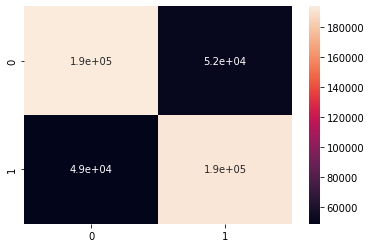

In [38]:
import seaborn as sns
sns.heatmap(cf, annot=True);

In [64]:
import joblib
joblib.dump(NN, "./model.joblib", compress=True)

['./model.joblib']